In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import re
import random
import string
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, Dense, Dropout, GlobalMaxPooling1D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pygments.lexers import CLexer
from pygments import lex
import time

In [ ]:
# Load Dataset
# Sample a subset to fit into memory while ensuring balanced classes
data_path = '/content/drive/MyDrive/704/MSR_data_cleaned.csv'

with open(data_path, 'r') as file:
    total_rows = sum(1 for _ in file)

chunk_size = 100000
chunks = []

# Identify rows with issues to skip
rows_to_skip = [188535]

for chunk in pd.read_csv(data_path, chunksize=chunk_size, on_bad_lines='skip', skiprows=rows_to_skip, low_memory=False):
    chunks.append(chunk)

df = pd.read_csv(data_path, on_bad_lines='skip', skiprows=rows_to_skip, low_memory=False)

In [ ]:
df = df.reset_index(drop=True)
print("Dataset shape:", df.shape)

Dataset shape: (188534, 36)


In [ ]:
# Prepare features and labels
np.random.seed(42)
df['vul'] = df['vul'].apply(lambda x: 1 if x > 0 else 0)
Y = df['vul'].values
X = df['func_before'].tolist()

In [ ]:
# Split the data into training, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, Y, test_size=0.20, random_state=42, stratify=Y)
X_train_original, X_val, y_train_original, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)  # 0.25 x 0.8 = 0.20

print(f"Training set size: {len(X_train_original)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 113120
Validation set size: 37707
Test set size: 37707


In [ ]:
# Check class distribution
def print_class_distribution(y, dataset_name):
    unique, counts = np.unique(y, return_counts=True)
    class_counts = dict(zip(unique, counts))
    print(f"Class distribution in {dataset_name} set:", class_counts)

# Print class distributions
print_class_distribution(y_train_original, "original training")
print_class_distribution(y_val, "validation")
print_class_distribution(y_test, "test")

Class distribution in original training set: {0: 106642, 1: 6478}
Class distribution in validation set: {0: 35547, 1: 2160}
Class distribution in test set: {0: 35547, 1: 2160}


In [ ]:
# Preprocessing and tokenization functions
def preprocess_code(code):
    code = re.sub(r'//.*', '', code)
    code = re.sub(r'/\*.*?\*/', '', code, flags=re.DOTALL)
    code = re.sub(r'".*?"', '', code)
    code = re.sub(r'\b[-+]?\d*\.?\d+\b', 'NUMBER', code)
    return code.strip()

def clexer_tokenize(code):
    lexer = CLexer()
    return [token[1] for token in lex(preprocess_code(code), lexer)]

In [ ]:
# List of C/C++ keywords to exclude
c_keywords = set([
    'auto', 'break', 'case', 'char', 'const', 'continue', 'default',
    'do', 'double', 'else', 'enum', 'extern', 'float', 'for', 'goto',
    'if', 'inline', 'int', 'long', 'register', 'restrict', 'return',
    'short', 'signed', 'sizeof', 'static', 'struct', 'switch', 'typedef',
    'union', 'unsigned', 'void', 'volatile', 'while', '_Alignas',
    '_Alignof', '_Atomic', '_Bool', '_Complex', '_Generic', '_Imaginary',
    '_Noreturn', '_Static_assert', '_Thread_local', 'NUMBER',
    # Add more C++ keywords
    'asm', 'bool', 'catch', 'class', 'const_cast', 'delete', 'dynamic_cast',
    'explicit', 'export', 'false', 'friend', 'mutable', 'namespace', 'new',
    'operator', 'private', 'protected', 'public', 'reinterpret_cast',
    'static_cast', 'template', 'this', 'throw', 'true', 'try', 'typeid',
    'typename', 'using', 'virtual', 'wchar_t'
])

def rename_variables(code):
    # Pattern to find identifiers (variable and function names)
    pattern = r'\b([a-zA-Z_][a-zA-Z0-9_]*)\b'

    # Find all identifiers in the code
    identifiers = set(re.findall(pattern, code))
    # Exclude keywords
    identifiers = identifiers - c_keywords

    # Create a mapping from original names to new random names
    new_names = {}
    for identifier in identifiers:
        # Generate a random name
        random_name = ''.join(random.choices(string.ascii_letters, k=8))
        new_names[identifier] = random_name

    # Replace identifiers in the code
    def replace_identifier(match):
        word = match.group(0)
        return new_names.get(word, word)

    # Replace all occurrences using the pattern
    augmented_code = re.sub(pattern, replace_identifier, code)
    return augmented_code


In [ ]:
def change_whitespace(code):
    lines = code.split('\n')
    new_lines = []
    for line in lines:
        # Randomly change indentation
        if line.strip():  # Ignore empty lines
            indent = ' ' * random.randint(0, 4)
            line = indent + line.lstrip()
        # Randomly add blank lines
        new_lines.append(line)
        if random.random() < 0.1:  # 10% chance to add a blank line
            new_lines.append('')
    augmented_code = '\n'.join(new_lines)
    return augmented_code


In [ ]:
def insert_comments(code):
    lines = code.split('\n')
    new_lines = []
    for line in lines:
        # Remove existing comments
        line = re.sub(r'//.*', '', line)
        line = re.sub(r'/\*.*?\*/', '', line, flags=re.DOTALL)

        new_lines.append(line)

        # Randomly insert a comment
        if random.random() < 0.2:  # 20% chance to insert a comment
            comment = '// ' + random.choice([
                'TODO: optimize this',
                'Check for null pointers',
                'Temporary fix',
                'Refactor needed',
                'Add error handling',
                'Functionality confirmed',
                'Review this code',
                'Ensure thread safety'
            ])
            new_lines.append(comment)
    augmented_code = '\n'.join(new_lines)
    return augmented_code


In [ ]:
def augment_code(code):
    # Randomly decide which augmentations to apply
    if random.random() < 0.7:  # 70% chance to rename variables
        code = rename_variables(code)
    if random.random() < 0.5:  # 50% chance to change whitespace
        code = change_whitespace(code)
    if random.random() < 0.3:  # 30% chance to insert comments
        code = insert_comments(code)
    return code


In [ ]:
# Apply data augmentation to training data
X_train_augmented = []
y_train_augmented = []

augmentation_factor = 2  # Number of augmented samples per original sample

for code, label in zip(X_train_original, y_train_original):
    # Add the original code
    X_train_augmented.append(code)
    y_train_augmented.append(label)

    # Generate augmented samples
    for _ in range(augmentation_factor):
        augmented_code = augment_code(code)
        X_train_augmented.append(augmented_code)
        y_train_augmented.append(label)

# Convert labels to NumPy arrays
y_train_augmented = np.array(y_train_augmented)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Check class distribution after augmentation
print_class_distribution(y_train_augmented, "augmented training")


Class distribution in augmented training set: {0: 319926, 1: 19434}


In [ ]:
# Tokenize training data
X_train_tokenized = [clexer_tokenize(code) for code in tqdm(X_train_augmented, desc="Tokenizing Augmented Training Data")]
X_val_tokenized = [clexer_tokenize(code) for code in tqdm(X_val, desc="Tokenizing Validation Data")]
X_test_tokenized = [clexer_tokenize(code) for code in tqdm(X_test, desc="Tokenizing Test Data")]

# Calculate token frequencies from the augmented training data
token_freq = Counter(token for tokens in X_train_tokenized for token in tokens)

# Determine frequency threshold (e.g., 95th percentile)
frequencies = list(token_freq.values())
threshold_frequency = np.percentile(frequencies, 95)

# Build vocabulary with tokens above the threshold frequency
vocab = {token: idx + 1 for idx, (token, freq) in enumerate(token_freq.items()) if freq >= threshold_frequency}
vocab_size = len(vocab)
print("Vocabulary size:", vocab_size)


Tokenizing Test Data: 100%|██████████| 37707/37707 [00:50<00:00, 747.34it/s]


Vocabulary size: 214063


In [ ]:
def tokens_to_integers(tokens):
    return [vocab.get(token, 0) for token in tokens]  # Use 0 for unknown tokens

X_train_seq = [tokens_to_integers(tokens) for tokens in X_train_tokenized]
X_val_seq = [tokens_to_integers(tokens) for tokens in X_val_tokenized]
X_test_seq = [tokens_to_integers(tokens) for tokens in X_test_tokenized]

In [ ]:
# Determine the maximum sequence length (e.g., 98th percentile)
sequence_lengths = [len(seq) for seq in X_train_seq + X_val_seq + X_test_seq]
max_length = int(np.percentile(sequence_lengths, 98))
print("Maximum sequence length:", max_length)

# Pad sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')


Maximum sequence length: 1504


In [ ]:
# Ensure that input data and labels are NumPy arrays
X_train_padded = np.array(X_train_padded)
X_val_padded = np.array(X_val_padded)
X_test_padded = np.array(X_test_padded)

In [ ]:
# Find out-of-bounds indices in X_train_padded
out_of_bounds_indices = np.where(X_train_padded >= vocab_size + 1)

# Print the coordinates of out-of-bounds indices
print("Out-of-bounds indices:", out_of_bounds_indices)

Out-of-bounds indices: (array([ 16179,  16179,  16179, ..., 339355, 339355, 339355]), array([19, 30, 43, ...,  2, 50, 70]))


In [ ]:
#Cap Indices
X_train_padded = np.clip(X_train_padded, 0, vocab_size) # Clip indices to the range [0, vocab_size]
X_val_padded = np.clip(X_val_padded, 0, vocab_size)
X_test_padded = np.clip(X_test_padded, 0, vocab_size)

In [ ]:
# Check shapes and types
print("Type of X_train_padded:", type(X_train_padded))
print("Shape of X_train_padded:", X_train_padded.shape)
print("Type of y_train_augmented:", type(y_train_augmented))
print("Shape of y_train_augmented:", y_train_augmented.shape)

Type of X_train_padded: <class 'numpy.ndarray'>
Shape of X_train_padded: (339360, 1504)
Type of y_train_augmented: <class 'numpy.ndarray'>
Shape of y_train_augmented: (339360,)


In [ ]:
# Ensure matching number of samples
assert X_train_padded.shape[0] == y_train_augmented.shape[0], "Mismatch in number of training samples and labels."

In [ ]:
# Build and compile the CNN model
embedding_dim = 100

model_CNN = Sequential()
model_CNN.add(Embedding(input_dim=vocab_size + 1, output_dim=embedding_dim, input_length=max_length, trainable=True))
model_CNN.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model_CNN.add(BatchNormalization())
model_CNN.add(GlobalMaxPooling1D())
model_CNN.add(Dense(64, activation='relu'))
model_CNN.add(Dropout(0.5))
model_CNN.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)
model_CNN.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

print(model_CNN.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_2               │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

start_time = time.time()
history_CNN = model_CNN.fit(
    X_train_padded, y_train_augmented,
    validation_data=(X_val_padded, y_val),
    epochs=20,
    batch_size=128,
    callbacks=[early_stopping],
    verbose=1
)
training_time = time.time() - start_time
print(f"Training time: {training_time:.2f} seconds")

Epoch 1/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 1743s 656ms/step - accuracy: 0.9632 - loss: 0.1322 - val_accuracy: 0.9843 - val_loss: 0.0516
Epoch 2/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 1669s 629ms/step - accuracy: 0.9763 - loss: 0.0797 - val_accuracy: 0.9848 - val_loss: 0.0545
Epoch 3/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 1776s 670ms/step - accuracy: 0.9803 - loss: 0.0666 - val_accuracy: 0.9850 - val_loss: 0.0580
Epoch 4/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 1935s 730ms/step - accuracy: 0.9825 - loss: 0.0584 - val_accuracy: 0.9834 - val_loss: 0.0769
Epoch 5/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 1922s 725ms/step - accuracy: 0.9837 - loss: 0.0552 - val_accuracy: 0.9851 - val_loss: 0.0685
Epoch 6/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 1938s 731ms/step - accuracy: 0.9852 - loss: 0.0503 - val_accuracy: 0.9842 - val_loss: 0.0719
Training time: 10988.49 seconds


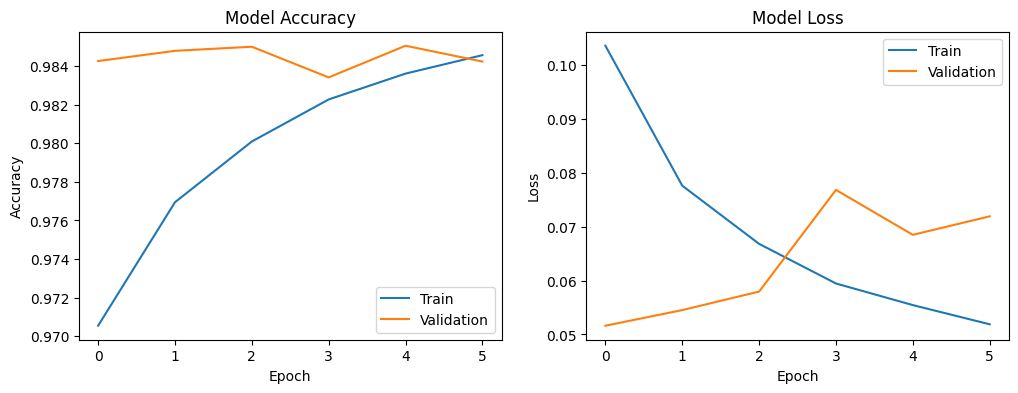

In [ ]:
# Evaluate the Model
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history_CNN)


1179/1179 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step
Test Accuracy: 0.9849
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     35547
           1       0.91      0.81      0.86      2160

    accuracy                           0.98     37707
   macro avg       0.95      0.90      0.93     37707
weighted avg       0.98      0.98      0.98     37707



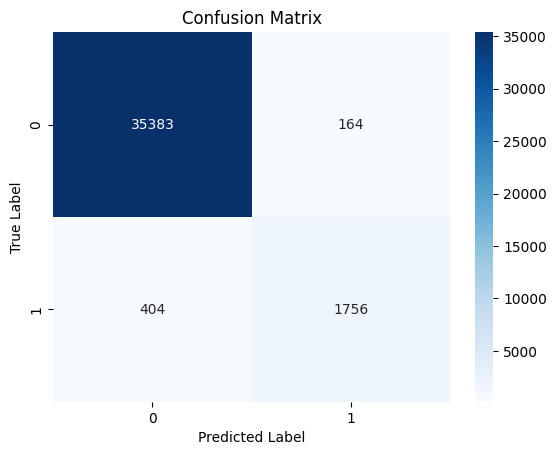

In [ ]:
# Evaluate on Test Set
# Predict on test data
y_test_pred_probs = model_CNN.predict(X_test_padded)
y_test_pred = (y_test_pred_probs > 0.5).astype("int32")

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
